# French Motor Insurance Coding Challenge

Welcome to the **first part** of the French Motor Insurance Coding Challenge. In this notebook, I will focus on **exploring the dataset** and preparing the features necessary for predicting insurance claim amounts.


**Objectives:**

1.	Explorative Datenanalyse (EDA): 
- *Goal*:  to familiarize myself with the data, identifying any potential issues such as missing values or outliers, and uncovering key statistical patterns. 
2.	Feature Engineering: 
-  *Goal*: After investigating the data, propose and create additional variables.


**Scope of This Notebook:**

- **No Modeling:** 
    - It’s important to note that this notebook does not include the actual modeling process. Instead, my focus here is on preparing the data to ensure that it is in optimal shape when I start building predictive models.
- **Next Steps:** 
    - In the following notebook, I will proceed with splitting the dataset into training and testing sets, scaling the features as necessary, and building and evaluating predictive models based on the work done here.

**Data Source**: 

The data for the notebook can be found here:
* Feature Data: [freMTPL2freq](https://www.openml.org/d/41214)
* Target Data: [freMTPL2sev](https://www.openml.org/d/41214)



---
## Importing Libraries

In [403]:
import os
import sys

from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import sklearn as sk
import scipy as sp

import scipy.stats as stats
from sklearn.datasets import fetch_openml

import sys
sys.path.append("..")

from helpers.helper_functions import *


custom_palette = ["#be4db2",
"#5dbb48",
"#7862cc",
"#b7b733",
"#6486c9",
"#d74a2c",
"#43bfc6",
"#ca3d51",
"#5ebe83",
"#de4f8a",
"#6d9a3a",
"#c887cb",
"#da9437",
"#9f4d6f",
"#3a8254",
"#ba5b2e",
"#67732a",
"#dd8377",
"#baae64",
"#966c32"]


---
## Loading Data

The dataset for this analysis is hosted on the [OpenML](https://www.openml.org/) platform, which provides a wide range of datasets for machine learning tasks. 

I will use the `fetch_openml` function to directly access and load the data into this notebook. This method allows for easy and efficient retrieval of datasets, ensuring that the latest version is always used.

In [404]:
#TODO: TRANSLATE INTO ENGLISH
# Abrufen der Claims-Daten von OpenMLx
print("Abrufen des 'freMTPL2sev'-Datensatzes von OpenML...")
try:
    df_claims = fetch_openml(name="freMTPL2sev", as_frame=True).data
    print("'freMTPL2sev'-Datensatz erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden des 'freMTPL2sev'-Datensatzes. Fehler: {e}")

# Abrufen der Features-Daten von OpenML
print("Abrufen des 'freMTPL2freq'-Datensatzes von OpenML...")
try:
    df_features = fetch_openml(name="freMTPL2freq", as_frame=True).data
    print("'freMTPL2freq'-Datensatz erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden des 'freMTPL2freq'-Datensatzes. Fehler: {e}")

# Anzeigen der ersten Zeilen beider DataFrames
print("\nVorschau des 'freMTPL2sev' (Claims-Daten):")
display(df_claims.head()) 
print(f'The shape of the dataframe: {df_claims.shape}')

print("\nVorschau des 'freMTPL2freq' (Features-Daten):")
display(df_features.head())
print(f'The shape of the dataframe: {df_features.shape}')
  

Abrufen des 'freMTPL2sev'-Datensatzes von OpenML...
'freMTPL2sev'-Datensatz erfolgreich geladen.
Abrufen des 'freMTPL2freq'-Datensatzes von OpenML...
'freMTPL2freq'-Datensatz erfolgreich geladen.

Vorschau des 'freMTPL2sev' (Claims-Daten):


,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


The shape of the dataframe: (26639, 2)

Vorschau des 'freMTPL2freq' (Features-Daten):


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,'Diesel',76,R72


The shape of the dataframe: (678013, 12)


The dataframe `freMTLP2freq` has unique id values and respective claim amount. The datafrma

In [405]:
#TODO: Translate into English

# Überprüfen, ob jede IDpol nur einen Datensatz hat, und anzeigen, bei welchen IDs es mehr als einen Anspruch gibt
id_counts = df_claims['IDpol'].value_counts()

# Anzeigen der IDs mit den meisten Ansprüchen (Top 10)
print("Top 10 IDs mit den meisten Ansprüchen:")
print(id_counts.head(10))

# Aggregieren der ClaimAmount nach IDpol, um sicherzustellen, dass die Summe der aggregierten Daten korrekt ist
df_claims_agg = df_claims.groupby('IDpol').agg({'ClaimAmount': 'sum'}).reset_index()

# Überprüfen, ob die aggregierte Summe der Ansprüche der ursprünglichen Summe entspricht
is_sum_equal = df_claims_agg['ClaimAmount'].sum() == df_claims['ClaimAmount'].sum()
print("Stimmen die aggregierten Summen mit den ursprünglichen Summen überein?", is_sum_equal)

Top 10 IDs mit den meisten Ansprüchen:
IDpol
2262511    66
2282134    36
2227533    25
2220367    24
2277846    23
2286775    21
2241683    16
3253234    11
3254353    11
2248174     9
Name: count, dtype: int64
Stimmen die aggregierten Summen mit den ursprünglichen Summen überein? True


In predictive modeling, it’s typical to have one DataFrame for the features (independent variables) and another for the target variable (dependent variable). To build a model, these two DataFrames must be merged into a single DataFrame, where each row represents a complete data point with both the features and the corresponding target variable.

In [406]:
df_merged = pd.merge(df_features, df_claims, on="IDpol")

df_merged.head(3)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,139.0,1,0.75,F,7,1,61,50,B12,'Regular',27000,R11,303.00
1,190.0,1,0.14,B,12,5,50,60,B12,'Diesel',56,R25,1981.84
2,414.0,1,0.14,E,4,0,36,85,B12,'Regular',4792,R11,1456.55


---
## Explorative Datenanalyse und Datenbereinigung

In this step, I will process the data to ensure its quality and readiness for analysis. I will focus on identifying and correcting outliers, missing values, and incorrect entries (such as typos or other anomalies). First, I will examine the data types of each variable to understand the structure of the dataset and determine whether any conversions or corrections are necessary.

#### Checking data types and creating target variable

I begin by examining the data types of the DataFrame. Notably, the IDpol variable is currently stored as `float64`, but it would be more appropriate as `int32` to optimize memory usage and ensure precision.

Additionally, some variables like VehGas are incorrectly typed and should be converted to categorical variables to reflect their true nature.

Furthermore, I will construct a new target feature by combining Density and ClaimAmount, which may provide valuable insights for the modeling process.

In [407]:
df_merged.dtypes

IDpol           float64
ClaimNb           int64
Exposure        float64
Area           category
VehPower          int64
VehAge            int64
DrivAge           int64
BonusMalus        int64
VehBrand       category
VehGas           object
Density           int64
Region         category
ClaimAmount     float64
dtype: object

In [408]:
#create target variable which is claim amount/exposure
df_merged['Target'] = df_merged['ClaimAmount'] / df_merged['Exposure']


#### Checking for missing values and duplicates

The next step is to check for missing values and duplicates. It’s essential to ensure that the dataset is complete and free of any duplicated variables. If any issues are found, they should be addressed promptly to maintain data integrity.

In [409]:
# Check for duplicated rows in the merged dataframe
num_duplicates = df_merged.duplicated().sum()
print(f'Number of duplicated rows in the dataframe: {num_duplicates}')

# Drop duplicated rows if any
if num_duplicates > 0:
    df_merged = df_merged.drop_duplicates()
    print(f'Duplicated rows have been dropped. New shape of the dataframe: {df_merged.shape}')
else:
    print('No duplicated rows found.')

# Check for missing values in the dataframe
total_missing_values = df_merged.isnull().sum().sum()
print(f'Total number of missing values in the dataframe: {total_missing_values}')

data_unprocessed = df_merged.copy()

Number of duplicated rows in the dataframe: 235
Duplicated rows have been dropped. New shape of the dataframe: (26209, 14)
Total number of missing values in the dataframe: 0


### First View at the Feature Data

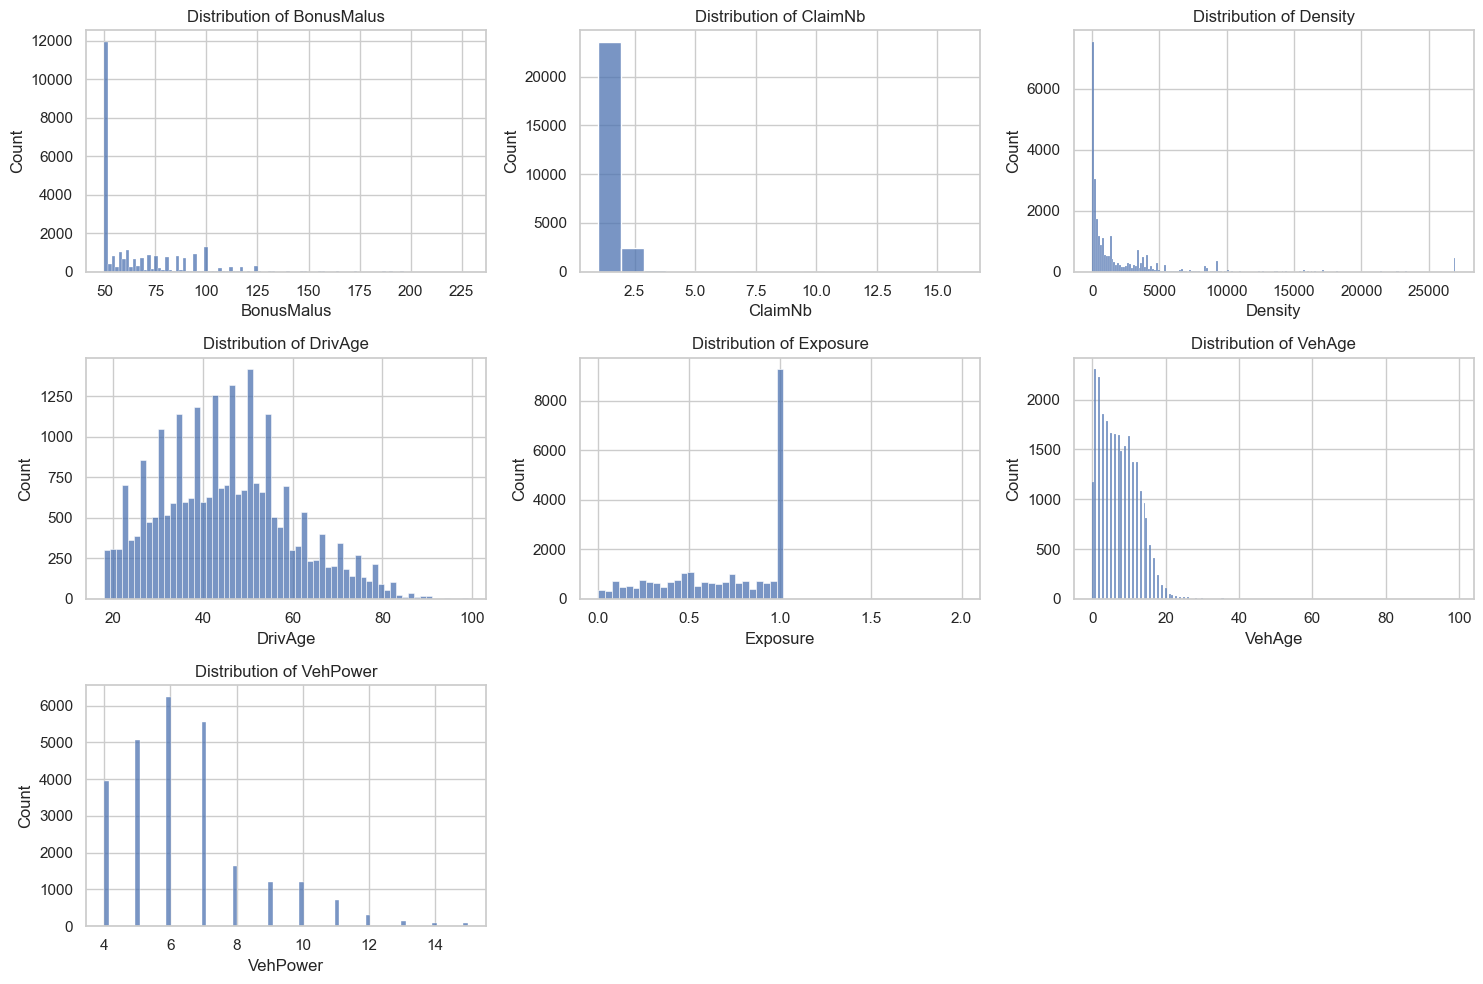

In [410]:
#plotting histograms for numerical features to understand their distribution (e.g., skewness, kurtosis), excluding target variable
numerical_features = df_merged.select_dtypes(include=[np.number]).columns.difference(['ClaimAmount','IDpol', 'Target'])
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_merged[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

1.	Distribution of BonusMalus: The data is highly skewed towards lower values, with most of the counts concentrated below 100.
2.	Distribution of ClaimNb: This variable has a strong peak at the lower values, particularly around 2.5, with very few instances beyond that.
3.	Distribution of Density: The density is also highly skewed, with the majority of the data concentrated towards the lower end, particularly below 5,000.
4.	Distribution of DrivAge: The age of drivers is more uniformly distributed compared to other variables, showing a peak between 40 and 60 years of age, and tapering off as age increases.
5.	Distribution of Exposure: Most of the data points are centered around 1.0, with a sharp spike, indicating a high concentration around this value.
6.	Distribution of VehAge: The vehicle age distribution is skewed towards newer vehicles, with most counts concentrated at lower ages.
7.	Distribution of VehPower: Vehicle power is also skewed, with the majority of data points clustered at lower power values, particularly between 4 and 8.


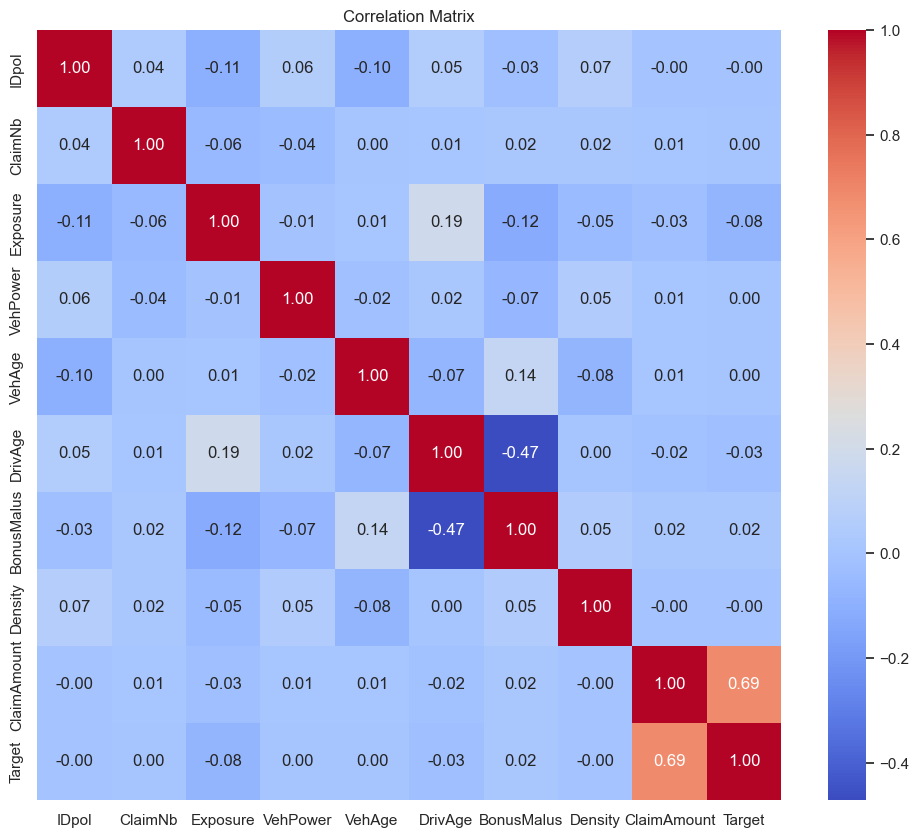

In [411]:
#creating intial corr matrix
corr = df_merged.select_dtypes(include=[np.number]).corr()

#plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**First Insights:**
1.	Skewed Distributions:
•	The data shows significant skewness in several variables, which could impact the performance of some models if not addressed.
2.	Correlations:
•	Most variables exhibit little to no correlation with the target variable. However, ClaimAmount shows a high positive correlation with the target variable. This correlation is expected, as the target variable is derived from ClaimAmount. To prevent data leakage during modeling, it is essential to exclude ClaimAmount from the feature set.

**Possible Next Steps:**

•	Log Transformation:
•	Given the skewness observed in Density, applying a log transformation during modeling could help normalize the distribution and improve model performance.
•	Feature Engineering:
•	Since Exposure is part of the target variable, we should consider creating bins for Exposure or exclude it from modeling to prevent the model from relying too heavily on this data.
•	Additionally, new features could be engineered to capture potential non-linear relationships suggested by the distributions. Binning VehAge might also be beneficial for modeling purposes.

### Examining categorical values

We start by reviewing the categorical variables to identify any potential issues, such as mistyped values or opportunities for optimization. This step is crucial to ensure that all categorical data is accurately classified and formatted. It also helps to determine if any adjustments or reclassifications are necessary to improve data quality and modeling effectiveness.


In [412]:
cat_columns = df_merged.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:
    #print unique values for each column and sort lists alphabetically
    print(f'Column {col} has {len(df_merged[col].unique().tolist())} unique values: {df_merged[col].unique().tolist()}')

Column Area has 6 unique values: ['F', 'B', 'E', 'A', 'D', 'C']
Column VehBrand has 11 unique values: ['B12', 'B1', 'B4', 'B3', 'B2', 'B5', 'B6', 'B14', 'B10', 'B11', 'B13']
Column VehGas has 2 unique values: ["'Regular'", "'Diesel'"]
Column Region has 22 unique values: ['R11', 'R25', 'R73', 'R93', 'R31', 'R21', 'R91', 'R22', 'R72', 'R52', 'R26', 'R82', 'R41', 'R94', 'R24', 'R83', 'R54', 'R23', 'R53', 'R74', 'R42', 'R43']


##### Area

In [413]:
df_merged['Area'].value_counts()

Area
C    7028
D    6403
E    6062
A    3336
B    2615
F     765
Name: count, dtype: int64

**Insights:**

•	The Area variable consists of six unique categories, labeled A through F.
•	There is a significant imbalance in the distribution, with categories C, D, and E being much more frequent than A, B, and especially F.
•	This imbalance could impact the modeling process, particularly if Area turns out to be an important predictor. Addressing this imbalance might be necessary to ensure robust model performance.

By performing an ANOVA, I can evaluate whether there are significant differences in the mean target variable across the various Area categories. A high p-value suggests that these differences are not statistically significant, indicating that some categories could potentially be merged. However, before merging Category B and Category F (the two smallest categories), it’s crucial to consider that they have markedly different mean values. This difference may justify keeping them separate to preserve the integrity of the data.


ANOVA p-value: 0.5657771868071726


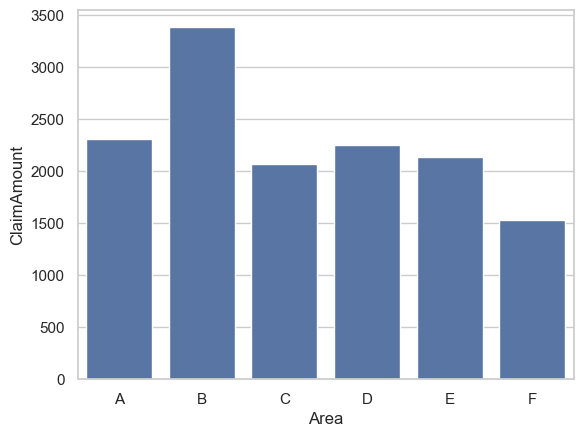

In [414]:
sns.barplot(df_merged.groupby('Area', observed=True)['ClaimAmount'].mean().sort_values())

# Check if Area F is significantly different

f_values, p_values = stats.f_oneway(
    *[group['Target'].values for name, group in df_merged.groupby('Area', observed=True)]
)


print("ANOVA p-value:", p_values)

Since the categories cannot be altered, I can instead create variables that capture the statistical description for each `Area`. This approach allows me to retain the original categories while still incorporating relevant statistical insights into the modeling process.

In [415]:
df_merged = create_stats_cols(df_merged, 'Area')

/Users/s.konchakova/GitHub/test/notebooks/../helpers/helper_functions.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = data.groupby(column).agg({


#### VehBrand

The DataFrame includes 14 different car brands, each with varying levels of representation. Brand B1 is the most prevalent, appearing 6,825 times, while B14 is the least popular among customers. Brands B10, B11, B13, and B14 are particularly underrepresented, and this imbalance needs to be addressed to ensure fair and accurate modeling.

In [416]:
df_merged['VehBrand'].value_counts()

VehBrand
B1     6825
B2     6736
B12    4172
B3     2410
B5     1648
B6     1240
B4     1095
B10     757
B11     661
B13     535
B14     130
Name: count, dtype: int64

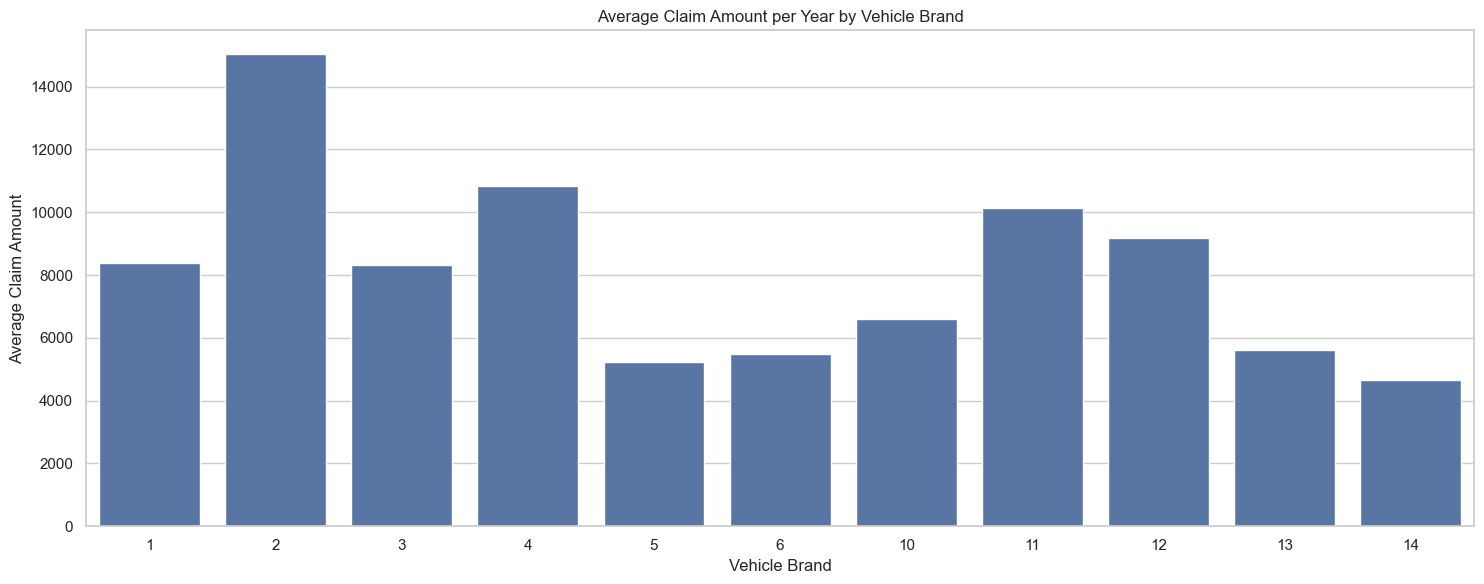

In [417]:
#create a barplot to show the average claim amount for each vehicle brand
#remove b from the name of the vehicle brands
df_merged['VehBrand'] = df_merged['VehBrand'].apply(lambda x: re.sub(r'\bB', '', x))

#convert to integer
df_merged['VehBrand'] = df_merged['VehBrand'].astype(int)

brand_claims = df_merged.groupby('VehBrand')['Target'].mean().reset_index()


# Sort the DataFrame
brand_claims_sorted = brand_claims.sort_values(by='VehBrand')

# Create the bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='VehBrand', y='Target', data=brand_claims_sorted)
plt.title('Average Claim Amount per Year by Vehicle Brand')
plt.xlabel('Vehicle Brand')
plt.ylabel('Average Claim Amount')
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

Some brands, such as B10, B11, B13, and B14, are underrepresented in the dataframe, yet they exhibit significant average claim amounts. To address this issue, several strategies can be considered:

**Possible Feature Engineering Approaches:**
1. **Frequency Binning:** 
   - Create bins to categorize brands into High Frequency, Medium Frequency, and Low Frequency groups based on their occurrence.
   
2. **Grouping Rare Brands:** 
   - Combine B10, B11, B13, and B14 into an "Others" category to reduce sparsity and simplify the analysis.

**Possible Modeling Approaches:**
1. **Resampling Techniques:** 
   - Apply resampling methods, such as oversampling the underrepresented brands or undersampling the overrepresented ones, to balance the data.

2. **Algorithm Selection:** 
   - Retain all categories as they are and experiment with algorithms specifically designed to handle imbalanced data, such as decision trees, random forests, or gradient boosting.

Each of these approaches can help ensure that the underrepresented brands are adequately considered in the analysis while maintaining the integrity of the model.

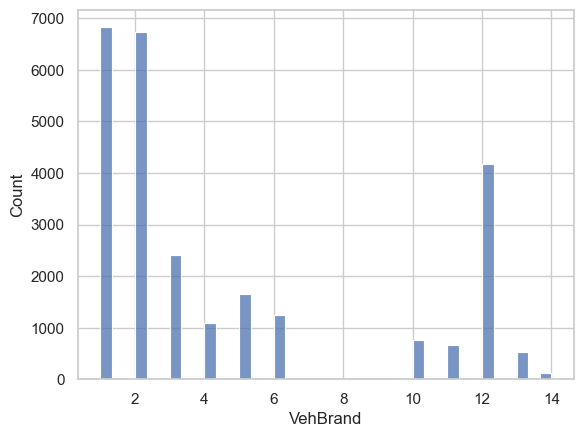

In [418]:
sns.histplot(df_merged['VehBrand'])
plt.show()

In [419]:
# create frequency bins
df_merged = create_brand_frequency_bins(df_merged, column='VehBrand', n_bins=3, labels = ['High', 'Medium', 'Low'])

#keep categories B10-B14 as 'Other'
df_merged['VehBrand'] = df_merged['VehBrand'].astype(str)
df_merged['VehBrand_Other'] = df_merged['VehBrand'].apply(lambda x: 'Other' if x in ['10', '11', '13', '14'] else x)

#convert back to categorical both VehBrand and VehBrand_Frequency
df_merged['VehBrand_Other'] = df_merged['VehBrand_Other'].astype('category')
df_merged['VehBrand'] = df_merged['VehBrand'].astype('category')
df_merged['VehBrand_Frequency'] = df_merged['VehBrand_Frequency'].astype('category')


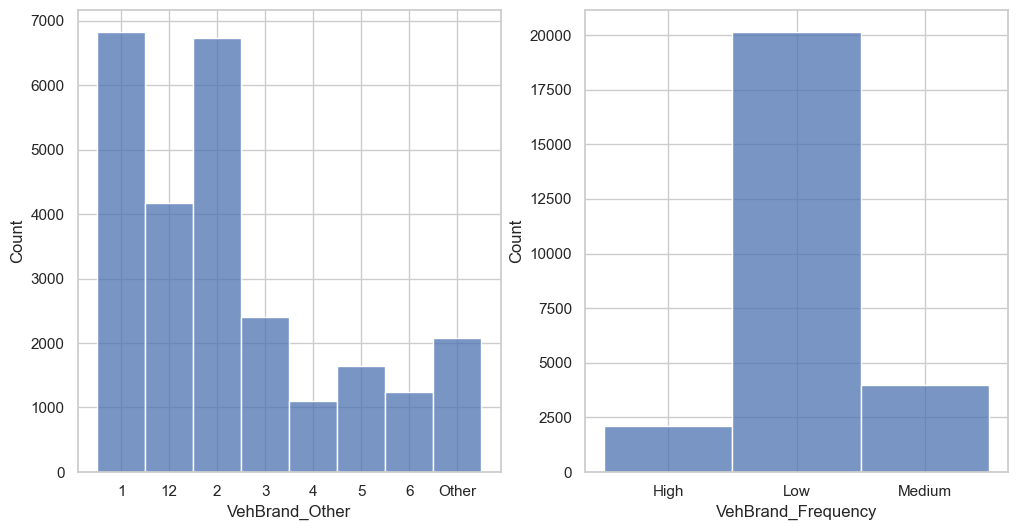

In [420]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_merged['VehBrand_Other'])
plt.subplot(1, 2, 2)
sns.histplot(df_merged['VehBrand_Frequency'], hue_order= df_merged['VehAge'])

plt.show()

It's challenging to determine whether certain brands are predominantly associated with newer or older vehicles. For example, Brand 12 has a higher proportion of newer vehicles, but overall, it's difficult to draw clear conclusions about the age distribution across different brands.

Given the potential imbalance in the `VehBrand_Frequency` data, it may be more effective to use the `VehBrand_Other` variable to simplify the analysis and mitigate issues related to data sparsity. This approach could lead to more reliable insights and better model performance.

#### VehGas

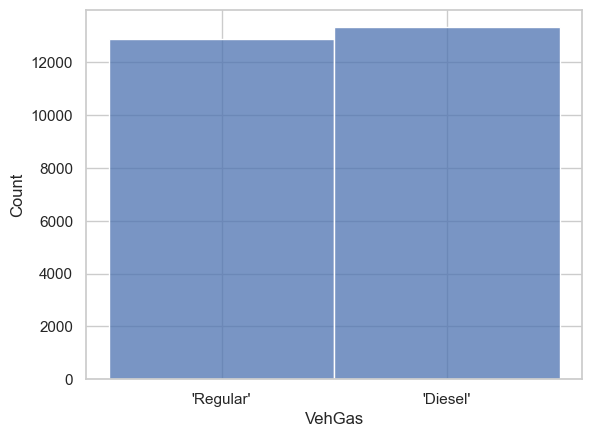

In [421]:
sns.histplot(df_merged['VehGas']);

In [422]:
#substitute "'Diesel' with 'D' and 'Regular' with 'R' in the VehGas column"
#convert to category
df_merged['VehGas'] = df_merged['VehGas'].apply(lambda x: re.sub(r"'Diesel'", 'D', x))
df_merged['VehGas'] = df_merged['VehGas'].apply(lambda x: re.sub(r"'Regular'", 'R', x))
df_merged['VehGas'] = df_merged['VehGas'].astype('category')

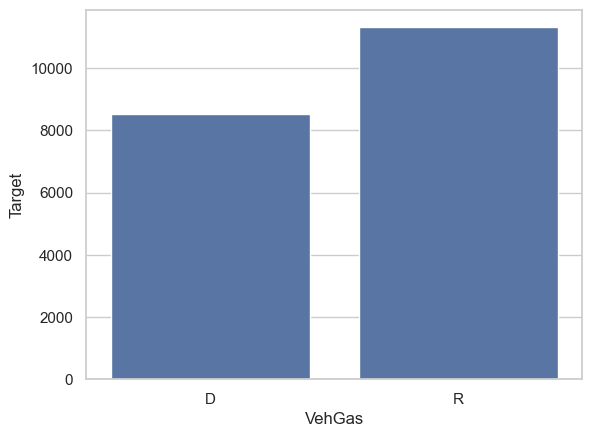

In [423]:
#plot claim amount for each fuel type and plot amount of the claims (claimnb) for each fuel type
sns.barplot(df_merged.groupby('VehGas', observed=True)['Target'].mean().sort_values());


Regular gas types show slightly higher average target values. Additionally, diesel cars are slightly more prevalent in the DataFrame compared to other fuel types.

#### Region

In [424]:
#analyse region 
df_merged['Region'].value_counts()

Region
R24    6421
R82    4200
R93    2960
R11    2572
R53    1848
R52    1553
R91    1054
R72    1047
R31     932
R54     796
R41     464
R25     448
R73     368
R26     343
R22     314
R23     219
R74     194
R83     140
R94     132
R42      90
R21      77
R43      37
Name: count, dtype: int64

In [425]:
len(df_merged['Region'].unique())

22

The DataFrame contains 22 different regions, with some regions being well-represented and having a high number of claims (e.g., R24, R82, R93), while others, like R43, have very few observations. Similar to my approach with VehicleBrand, I can consider creating bins or grouping the underrepresented regions into an "Other" category. However, before doing so, I will perform an ANOVA test to ensure that such grouping is statistically justified.

Additionally, I will generate descriptive statistics for each region to gain further insights into their characteristics.

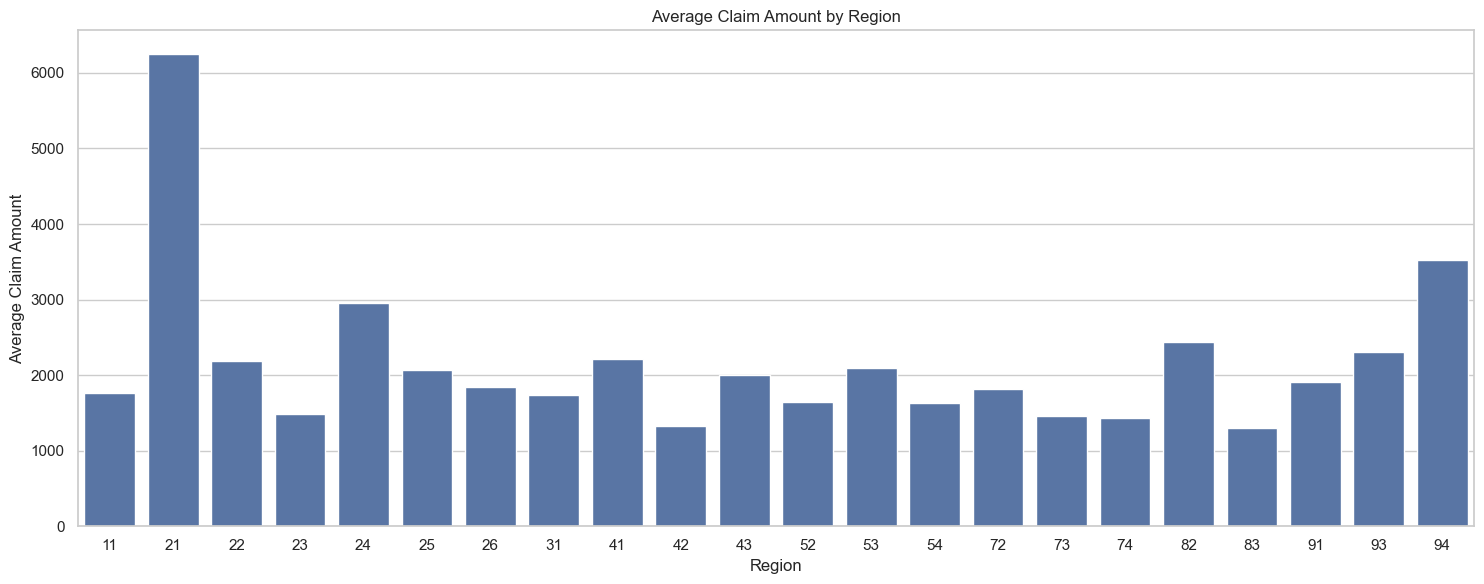

In [426]:
#convert to str
df_merged['Region'] = df_merged['Region'].astype(str)
#remove R from the brand name
df_merged['Region'] = df_merged['Region'].apply(lambda x: re.sub(r'\bR', '', x))

#convert to integer
df_merged['Region'] = df_merged['Region'].astype(int)
# Create the bar plot


plt.figure(figsize=(15, 6))
sns.barplot(x='Region', y='ClaimAmount', data=df_merged, errorbar=None)
plt.title('Average Claim Amount by Region')
plt.xlabel('Region')
plt.ylabel('Average Claim Amount')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show();

The situation with Regions is similar to that of Vehicle Brand. While Region 21 is underrepresented, it still has a very high average claim amount. To address this, I can group regions into frequency bins and generate descriptive statistics for each bin. It’s important to note that I cannot use the claim amount in this process to avoid data leakage.

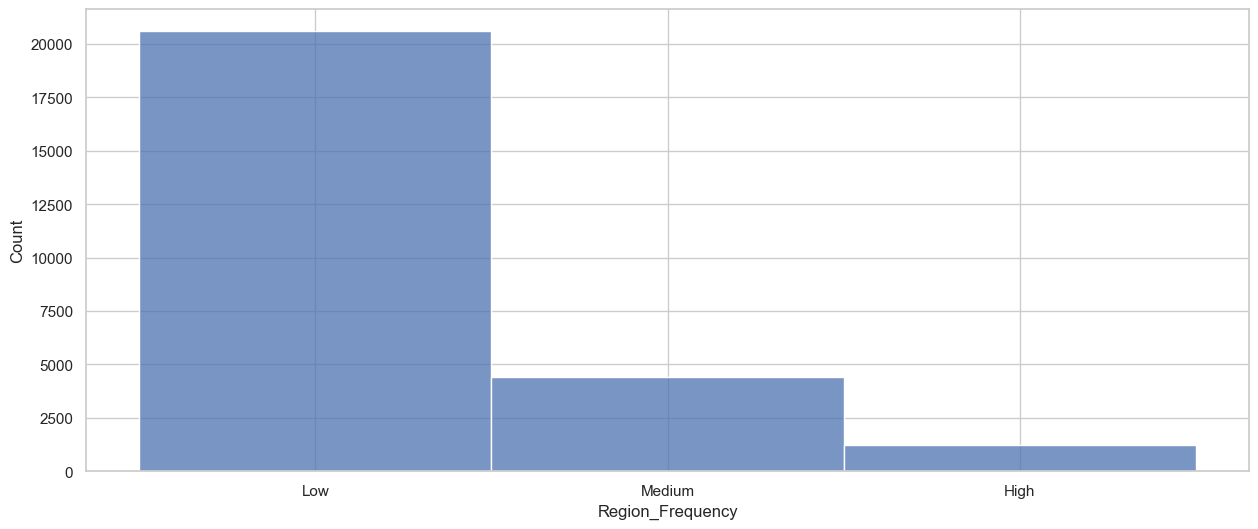

In [427]:
from helpers.helper_functions import *
df_merged = create_brand_frequency_bins(df_merged, column= 'Region', n_bins=3)

plt.figure(figsize=(15,6))
sns.histplot(df_merged['Region_Frequency'])
plt.show()

In [428]:
#get the regions with less than 500 observations and merge them to the group Others
regions_to_merge = df_merged['Region'].value_counts()[df_merged['Region'].value_counts() < 500].index.tolist()
df_merged['Region_other'] = df_merged['Region'].apply(lambda x: 'Other' if x in regions_to_merge else x)


In [429]:
df_merged = create_stats_cols(df_merged, 'Region')
df_merged = create_stats_cols(df_merged, 'Region_other')


#### Veh Power

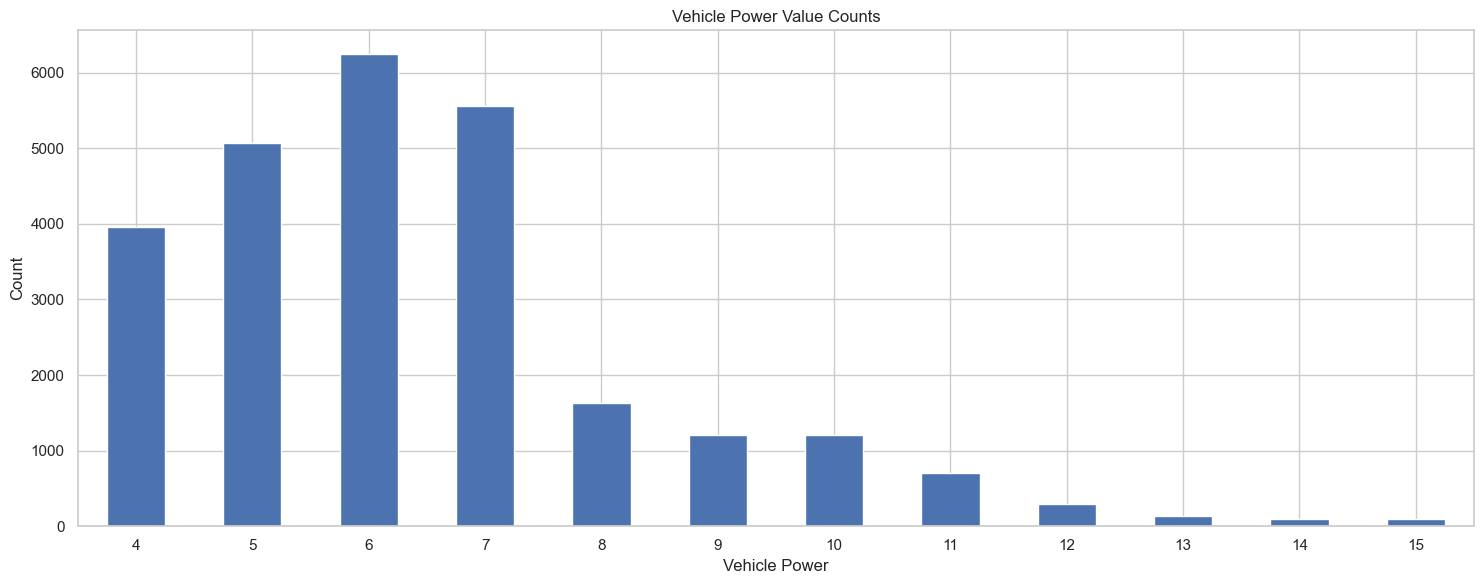

In [430]:
#convert to integer for plotting purposes
df_merged['VehPower'] = df_merged['VehPower'].astype(int)

#plot value counts for each vehicle power
plt.figure(figsize = (15, 6 ))
df_merged['VehPower'].value_counts().sort_index().plot(kind='bar')
plt.title('Vehicle Power Value Counts')
plt.xlabel('Vehicle Power')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Very imbalanced representation, can create bins for the very powerful, medium power and low power bins and try with both of them for modeling.

In [431]:
# Binning VehPower into 3 categories
bins = [4, 5, 6, 7, 10, 15]
labels = [1, 2, 3, 4, 5]
#where one is lower power, 2 is medium power and 3 is high power
df_merged['VehPower_binned'] = pd.cut(df_merged['VehPower'], bins=bins, labels=labels)

#the binned vehpower will be converted to integer to keep the representation that higher value means higher power
df_merged['VehPower_binned'] = df_merged['VehPower_binned'].astype('category')



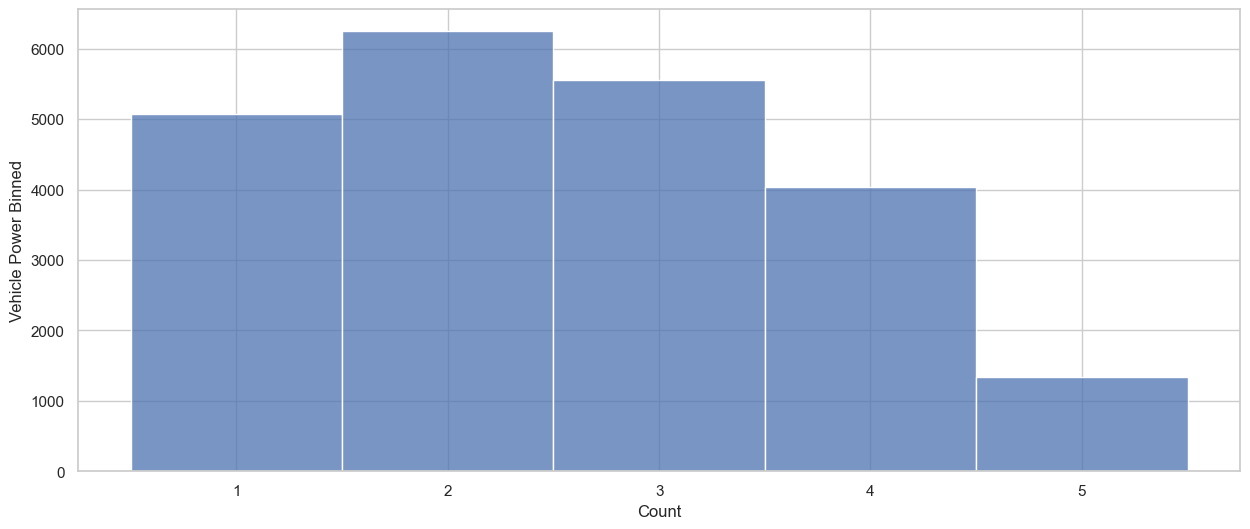

In [432]:
plt.figure(figsize = (15,6))

sns.histplot(df_merged['VehPower_binned'])
plt.xlabel('Count')
plt.ylabel('Vehicle Power Binned')
plt.show()

In [433]:
#drop VehBrand column
df_merged = df_merged.drop('VehBrand', axis = 1)

### Numeric Features

In this section, I will focus on analyzing the numeric features within the dataset. This involves examining their distributions, identifying any potential outliers, and exploring their relationships with the target variable. Understanding the characteristics of these numeric features is crucial for effective feature engineering and model development. This analysis will help inform any necessary transformations or adjustments to improve the performance and accuracy of the predictive model.

#### IDpol & ClaimAmount
I will convert IDpol to int32 to optimize memory usage. 

In [434]:
#convert IDpol to int32 and convert VehGas into a binary variable 
df_merged['IDpol'] = df_merged['IDpol'].astype(np.int32)

####    Exposure

Exposure represents the exposure period, a feature that is directly involved in the construction of our target variable. While it might generally be inadvisable to use the Exposure variable, given its role in defining the target, it shows a low correlation with the target variable. Therefore, it can be retained in the model without significant concern for data leakage.

In [435]:
df_merged['Exposure'].describe()

count    26209.000000
mean         0.691141
std          0.313415
min          0.002740
25%          0.440000
50%          0.760000
75%          1.000000
max          2.000000
Name: Exposure, dtype: float64

The data ranges are acceptable, though the distribution is skewed to the right. To add more insight, I can create an additional binary variable that indicates whether the customer has used insurance for less than a year or over a year. This new feature may help capture important patterns related to the duration of insurance usage.

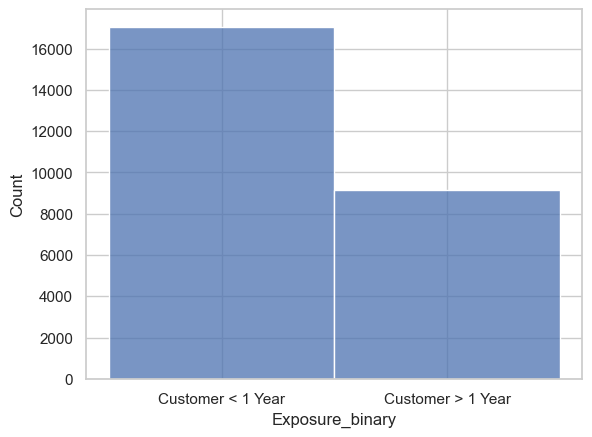

In [436]:
df_merged['Exposure_binary'] = np.where(df_merged['Exposure'] < 1, 'Customer < 1 Year', 'Customer > 1 Year')
sns.histplot(df_merged['Exposure_binary'])
plt.show()

Most customers are relatively new, indicating a shorter duration of insurance coverage. Additionally, I can create a new variable that represents the frequency of claims per customer. This variable could provide valuable insights into customer behavior and help improve the predictive accuracy of the model.

In [437]:
#create frequency (per year) of claims
df_merged['ClaimFrequency'] = df_merged['ClaimNb'] / df_merged['Exposure']
df_merged['ClaimFrequency'].describe()

count    26209.000000
mean         3.477434
std         11.120600
min          0.500000
25%          1.000000
50%          1.428571
75%          2.564103
max        365.000000
Name: ClaimFrequency, dtype: float64

#### DrivAge

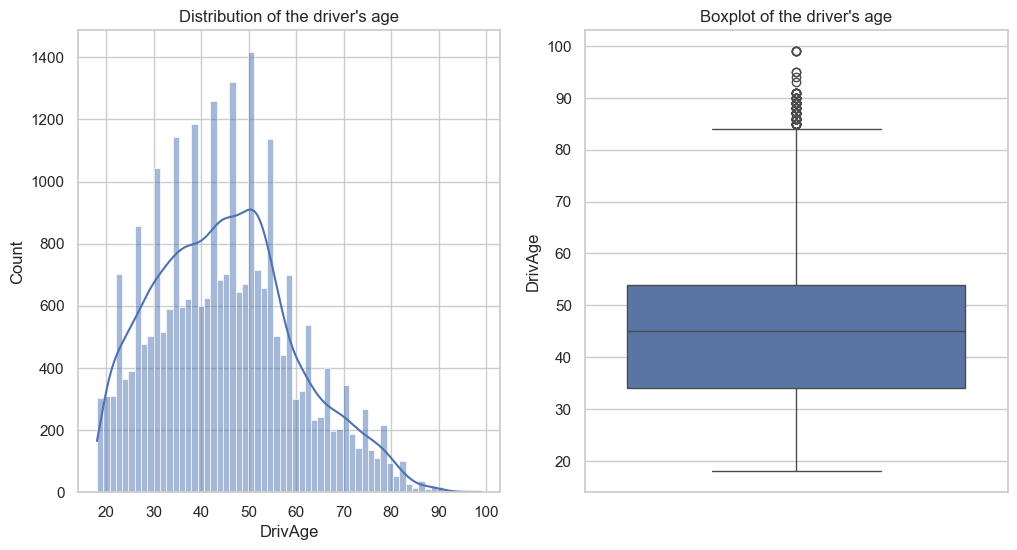

In [438]:
#make 2 figures, one for the distribution of the driver's age and one for the distribution of the driver's age with a boxplot
# #stack them side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_merged['DrivAge'], kde=True)
plt.title('Distribution of the driver\'s age')
plt.subplot(1, 2, 2)
sns.boxplot(y=df_merged['DrivAge'])
plt.title('Boxplot of the driver\'s age')
plt.show()

1.	**Distribution of Driver’s Age (Left Plot)**: 
- The histogram shows that the majority of drivers are between 30 and 50 years old, with a peak around 50 years. The distribution then tapers off towards both younger and older ages.
2.	**Boxplot of Driver’s Age (Right Plot)**: 
- The boxplot confirms that the interquartile range (IQR) is concentrated around ages 30 to 50, with a median age slightly above 40. There are some outliers, particularly for drivers over 80 years old, which are shown as individual points above the whiskers of the boxplot.

In [439]:
# Define the bins and corresponding labels
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-100']

# Create a new column with the binned age groups
df_merged['DrivAge_binned'] = pd.cut(df_merged['DrivAge'], bins=bins, labels=labels, right=False)

# Display the first few rows to see the new binned column
print(df_merged[['DrivAge', 'DrivAge_binned']].head())

   DrivAge DrivAge_binned
0       61          56-65
1       50          46-55
2       36          36-45
3       51          46-55
4       51          46-55


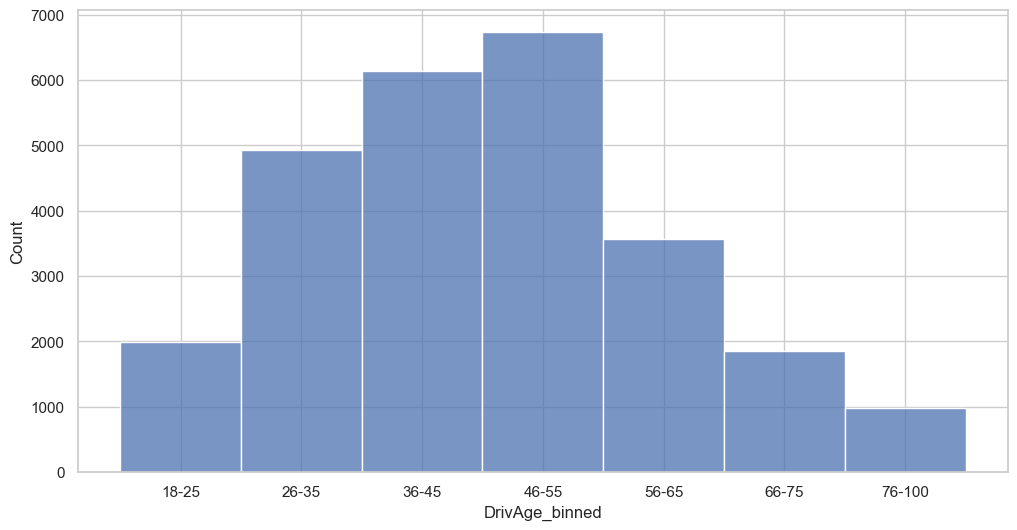

In [440]:
plt.figure(figsize=(12, 6))
sns.histplot(df_merged['DrivAge_binned'])
plt.show()

- Most Common Age Group: The most common age group is 46-55 years, with nearly 7,000 drivers in this range. This suggests that middle-aged drivers are the most frequently represented in this dataset.
- Symmetry: The distribution exhibits an approximately symmetrical shape, with a gradual increase in frequency from the younger age groups (18-25, 26-35) to the middle age groups (46-55), followed by a gradual decline as age exceeds 55.
- Younger Drivers: The age groups 18-25 and 26-35 have fewer drivers compared to the middle age groups, with the 18-25 group being the least represented.
- Older Drivers: The number of drivers steadily decreases as age surpasses 55, with the 76-100 age group having the fewest drivers. This indicates a significantly lower representation of older drivers in this dataset.
- Overall Shape: The distribution forms a bell-like curve, peaking in the middle age ranges and tapering off at both the younger and older extremes.

Additionally, assuming that people in France begin driving at age 18, we can estimate the driver’s experience by calculating the difference between their current age and 18.

In [441]:
df_merged['DriverExperience'] = df_merged['DrivAge'] - 18




#### Vehicle Age

The Vehicle Age variable contains values ranging from 0 to 99 years, which appears unrealistic. The data shows a clear right skew, so it should be addressed to ensure more accurate analysis.

In [442]:
df_merged['VehAge'].describe()

count    26209.000000
mean         7.343928
std          5.160917
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         99.000000
Name: VehAge, dtype: float64

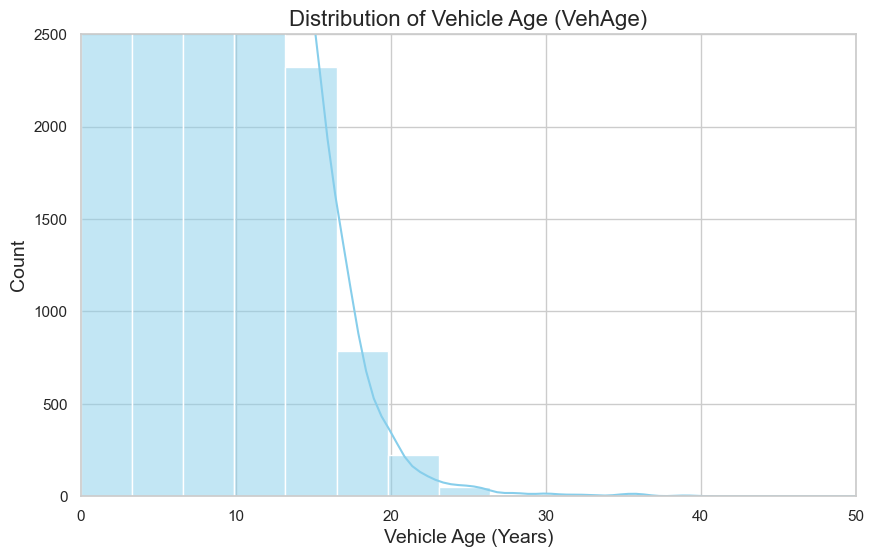

In [443]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(df_merged['VehAge'], bins=30, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Vehicle Age (VehAge)', fontsize=16)
plt.xlabel('Vehicle Age (Years)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set limits for better focus
plt.xlim(0, 50)  # Focusing on the age range with data
plt.ylim(0, 2500)  # Adjust as per your data range

# Show the plot
plt.show()

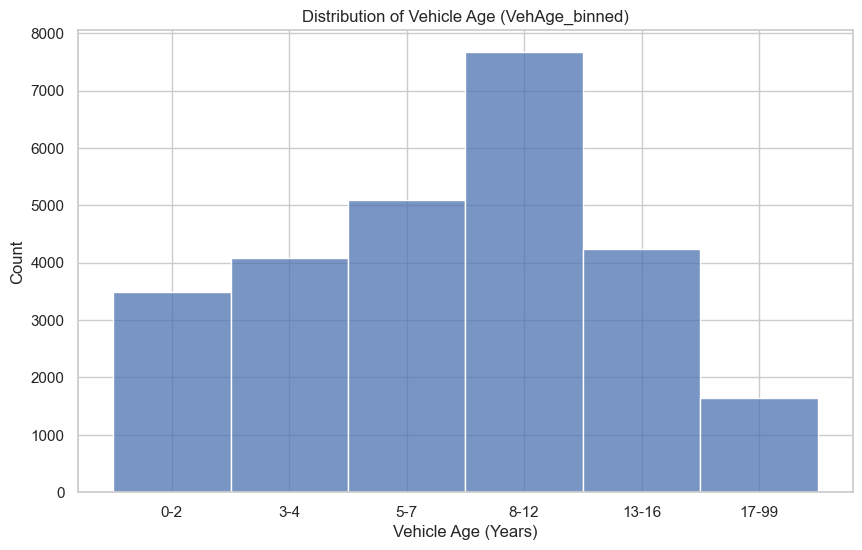

In [444]:
# create bins for the vehicle ages where bins are 2 years wide for the age below 10 and 3 years wide for the age above 10
bins = [0, 2, 4, 7, 12, 16, 100]
labels = ['0-2',  '3-4', '5-7', '8-12', '13-16', '17-99']

# Create a new column with the binned age groups
df_merged['VehAge_binned'] = pd.cut(df_merged['VehAge'], bins=bins, labels=labels, right=False)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['VehAge_binned'], kde=False)
plt.title('Distribution of Vehicle Age (VehAge_binned)')
plt.xlabel('Vehicle Age (Years)')
plt.show()



/var/folders/6_/0lgr7hf176vfq1tj2rpqg19m0000gp/T/ipykernel_2659/1473551804.py:2: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.barplot(x='DrivAge_binned', y='Target', data=df_merged, hue='VehAge_binned', errorbar=None, palette = custom_palette)


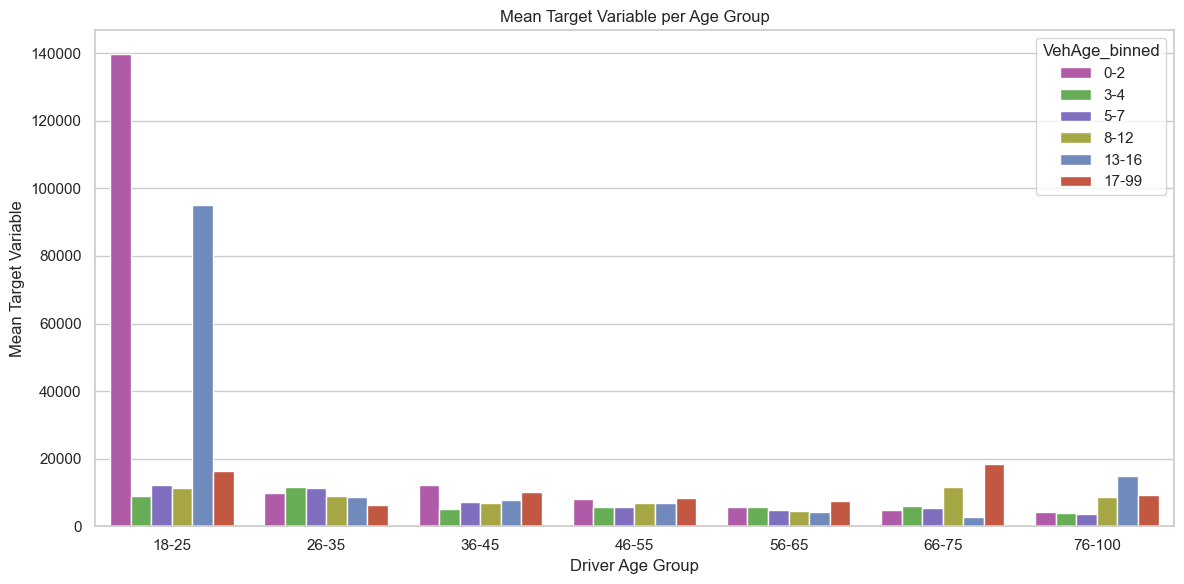

In [445]:
plt.figure(figsize=(12, 6))
sns.barplot(x='DrivAge_binned', y='Target', data=df_merged, hue='VehAge_binned', errorbar=None, palette = custom_palette)
plt.title('Mean Target Variable per Age Group')
plt.xlabel('Driver Age Group')
plt.ylabel('Mean Target Variable')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show();


- 18-25 Age Group: The mean target variable is extremely high for very young vehicles (0-2 years), followed by a significant but lower mean for vehicles aged 8-12 years. This suggests that young drivers with new cars or cars aged 8-12 years tend to have higher insurance claims per year.
- 26-35 to 66-75 Age Groups: For these middle-aged groups, the mean target values are relatively lower and more consistent across different vehicle age bins, indicating less variability in the target variable compared to younger drivers.
- 76-100 Age Group: There is a slight increase in the mean target variable for older drivers, particularly for vehicles aged 13-16 years and 17-99 years, though the overall levels are still much lower compared to the youngest age group.

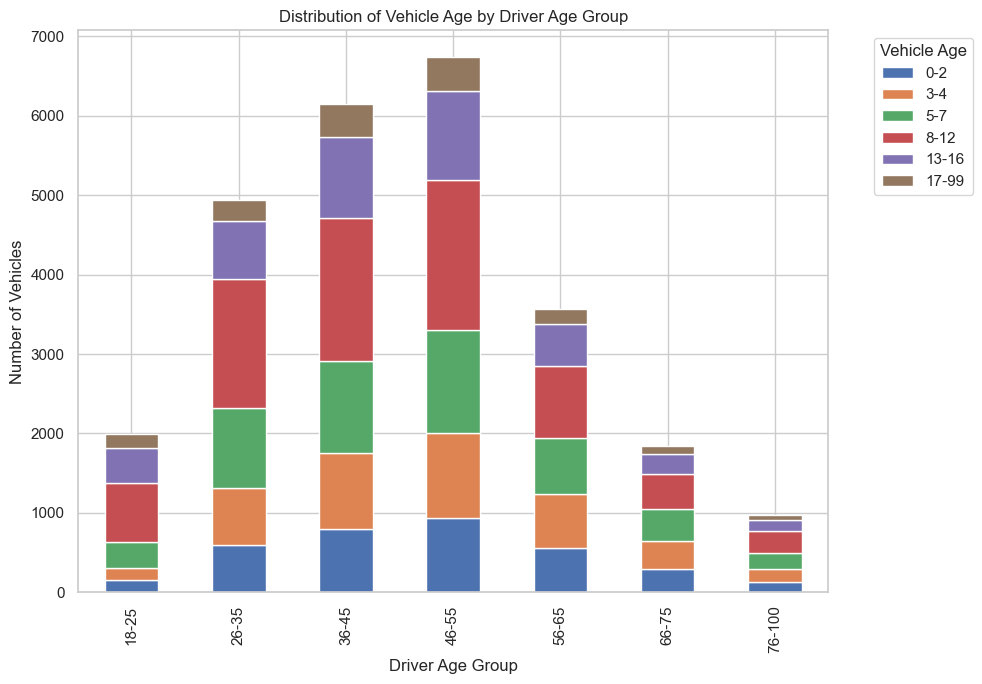

In [446]:
age_group_distribution = df_merged.groupby(['DrivAge_binned', 'VehAge_binned'], observed=True).size().unstack()


age_group_distribution.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Distribution of Vehicle Age by Driver Age Group')
plt.xlabel('Driver Age Group')
plt.ylabel('Number of Vehicles')
plt.legend(title='Vehicle Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show();

- Driver Age 36-55: The 36-45 and 46-55 age groups have the highest number of vehicles overall. In these groups, vehicles aged 8-12 years (red) are the most common, followed by vehicles aged 5-7 years (green) and 0-2 years (blue).
- Driver Age 18-25: The youngest driver group (18-25) has significantly fewer vehicles compared to older groups. In this age group, newer vehicles (0-2 years) are relatively more common.
 - Driver Age 56-75: For the 56-65 and 66-75 age groups, vehicles aged 8-12 years (red) continue to be prominent, but the overall number of vehicles decreases compared to younger age groups.
 - Driver Age 76-100: The oldest driver group (76-100) has the fewest vehicles, with a more even distribution across vehicle age categories, though the numbers are much lower overall.

/var/folders/6_/0lgr7hf176vfq1tj2rpqg19m0000gp/T/ipykernel_2659/378402783.py:3: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.histplot(x='VehBrand_Other', data=df_merged, hue='VehAge_binned', palette=custom_palette, multiple='stack')
/var/folders/6_/0lgr7hf176vfq1tj2rpqg19m0000gp/T/ipykernel_2659/378402783.py:13: UserWarning: The palette list has more values (20) than needed (7), which may not be intended.
  sns.histplot(x='VehBrand_Other', data=df_merged, hue='DrivAge_binned', palette=custom_palette, multiple='stack')


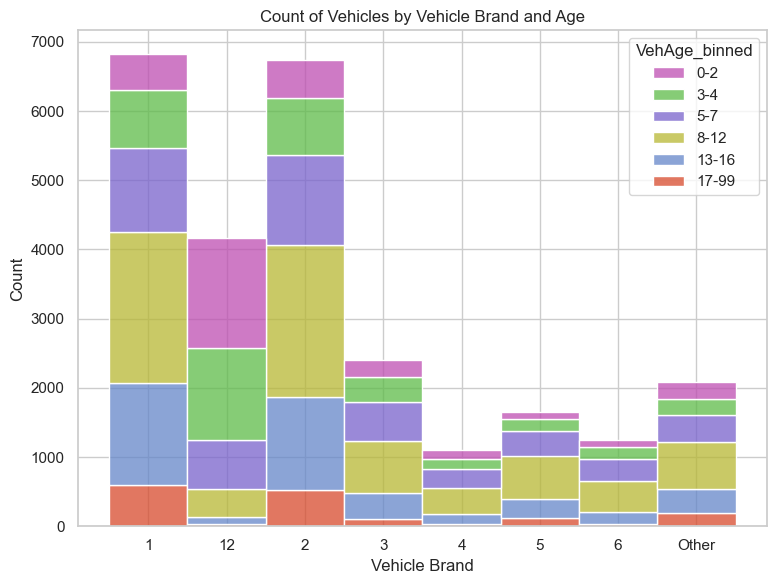

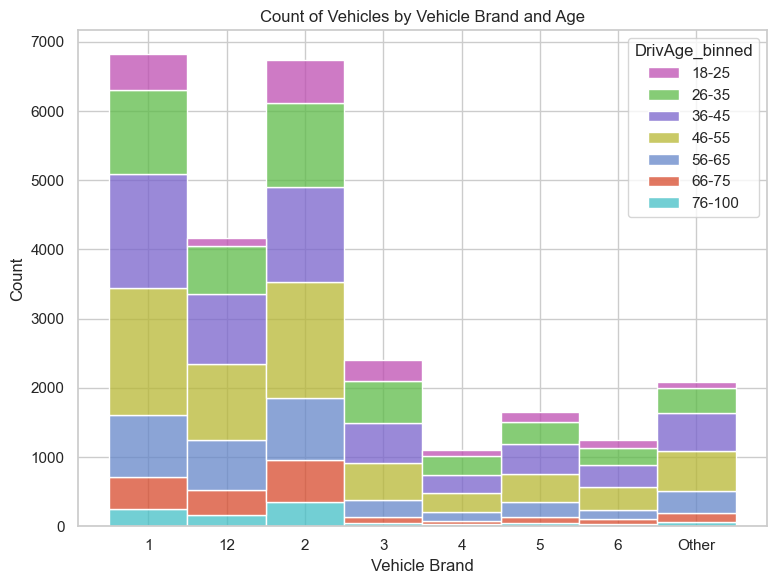

In [447]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.histplot(x='VehBrand_Other', data=df_merged, hue='VehAge_binned', palette=custom_palette, multiple='stack')    
plt.title('Count of Vehicles by Vehicle Brand and Age')
plt.xlabel('Vehicle Brand')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()


plt.figure(figsize=(15, 6))
plt.subplot(1,2,2)
sns.histplot(x='VehBrand_Other', data=df_merged, hue='DrivAge_binned', palette=custom_palette, multiple='stack')    
plt.title('Count of Vehicles by Vehicle Brand and Age')
plt.xlabel('Vehicle Brand')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout() 

1.	Vehicle Brand Representation:
- Brands 1 and 12 have the highest number of vehicles, with each having around 7,000 vehicles. These brands are significantly more represented in the dataset compared to others.
 - Other brands (labeled as “Other”) and Brands 3, 4, 5, and 6 have considerably fewer vehicles, indicating a less prominent presence in the dataset.
2.	Vehicle Age Distribution:
- For the most popular brands (1 and 12), there is a relatively balanced distribution across vehicle age bins, with a slight emphasis on vehicles aged 8-12 years (green) and 5-7 years (teal).
- In contrast, the less represented brands (3, 4, 5, 6, and Other) show a more even spread across vehicle ages, with no single age group dominating.

### BonusMalus and Density


In [448]:
df_merged['BonusMalus'].describe()

count    26209.000000
mean        65.131253
std         20.042132
min         50.000000
25%         50.000000
50%         55.000000
75%         76.000000
max        228.000000
Name: BonusMalus, dtype: float64

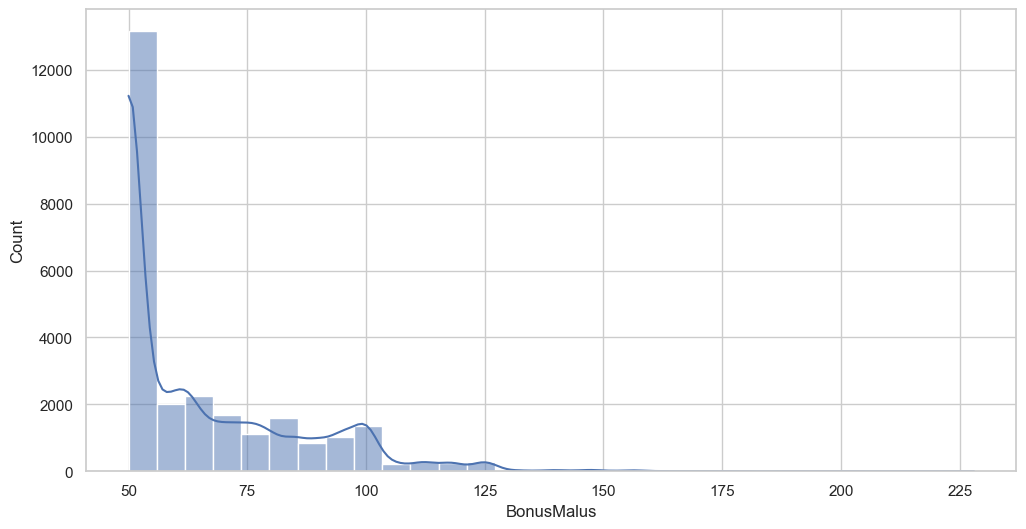

In [449]:
plt.figure(figsize=(12, 6))
#plot frequency barchart
sns.histplot(df_merged['BonusMalus'], bins=30, kde=True)
plt.show()


/var/folders/6_/0lgr7hf176vfq1tj2rpqg19m0000gp/T/ipykernel_2659/2849589440.py:4: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.barplot(x='DrivAge_binned', y='BonusMalus', data=df_merged, hue='VehAge_binned', errorbar=None, palette = custom_palette)


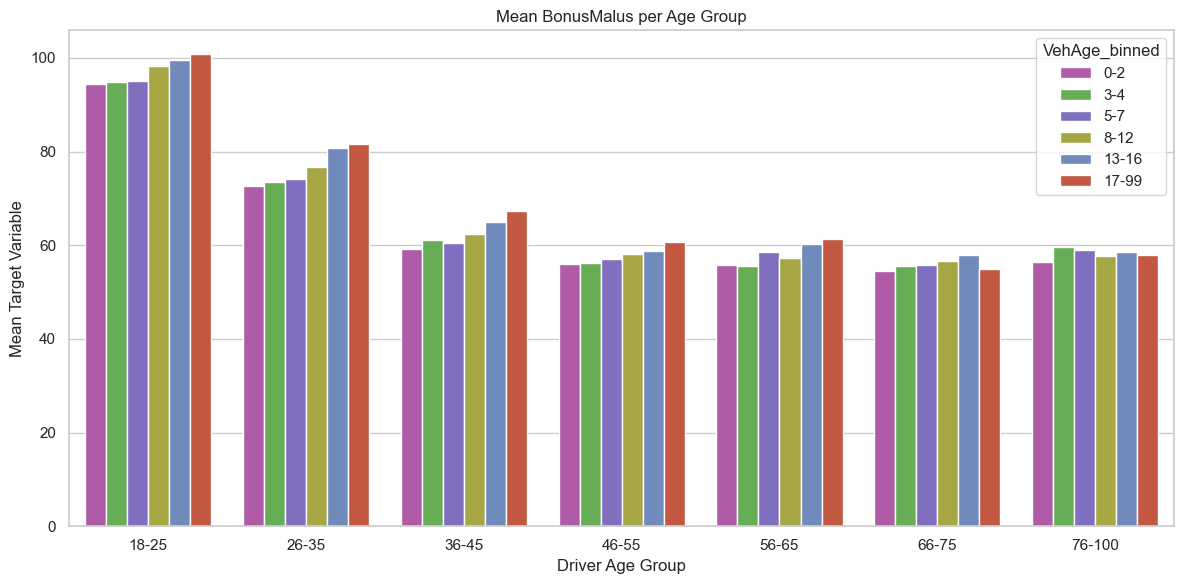

In [450]:
#create a bar plot with mean target variable per age group and vehicle age as color, define hue manually

plt.figure(figsize=(12, 6))
sns.barplot(x='DrivAge_binned', y='BonusMalus', data=df_merged, hue='VehAge_binned', errorbar=None, palette = custom_palette)
plt.title('Mean BonusMalus per Age Group')
plt.xlabel('Driver Age Group')
plt.ylabel('Mean Target Variable')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [451]:
f'The percentage of values with BonusMalus over 150 is {df_merged[df_merged["BonusMalus"] > 150].shape[0] / df_merged.shape[0] * 100:.2f}%'


'The percentage of values with BonusMalus over 150 is 0.18%'

I can create several new variables with the use of BonusMalus:

- RiskScore: This feature will quantify the relative riskiness of a driver by comparing their age to their BonusMalus score. A lower RiskScore might suggest that younger drivers, who are typically considered riskier, have a higher malus.
- Binary BonusMalus Variable: Converting the BonusMalus feature into a binary categorical variable can differentiate between drivers with bonuses and those with malus, potentially revealing its impact on claim amounts.


In [452]:
#add variable RiskScore RiskScore = DrivAge / BonusMalus
df_merged['RiskScore'] = df_merged['DrivAge'] / df_merged['BonusMalus']
#create bonus/malus class
df_merged['BonusMalusClass'] = np.where(df_merged['BonusMalus'] < 100, 'Bonus', 'Malus')

#### Density

Let’s take a closer look at the distribution of the density variable.

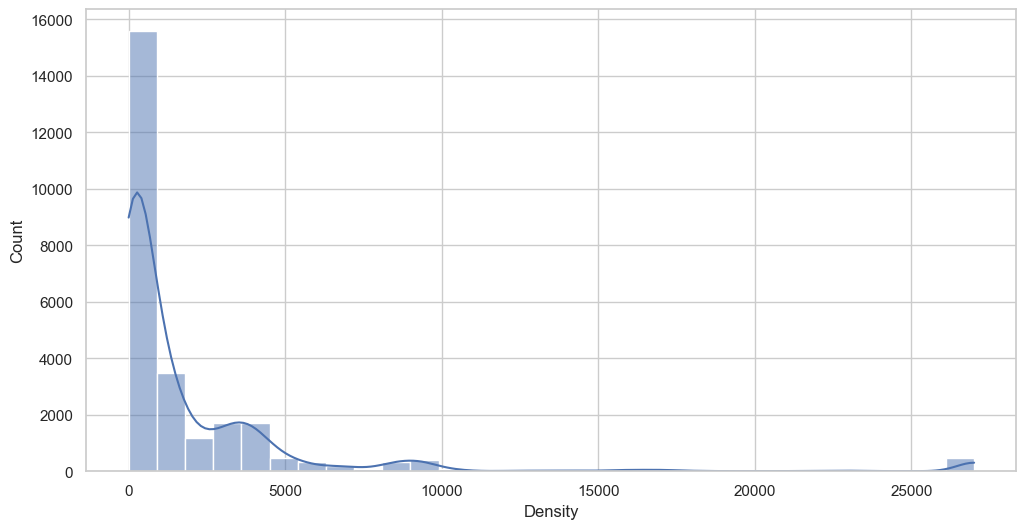

In [453]:
# plot distribution of the density
plt.figure(figsize=(12, 6))
sns.histplot(df_merged['Density'], bins=30, kde=True)
plt.show()


1.	Distribution Shape:
- The distribution of Density is heavily right-skewed, with the majority of the data concentrated on the lower end of the scale. Most of the density values fall between 0 and 2,500.
- As the density values increase, the frequency drops sharply, with very few observations having density values above 5,000.
2.	High Concentration at Lower Values:
- There is a significant peak around the lower density values, indicating that a large portion of the data points have low density. This could suggest that many of the observations are from less densely populated areas.
3.	Long Tail:
- The distribution has a long tail extending towards higher density values, up to 25,000 and beyond. However, the frequency of these high-density values is extremely low, indicating that such cases are rare in the dataset.
4.	Implications for Analysis:
- The heavy right skew and the presence of a long tail suggest that the raw Density variable may not be suitable for certain types of analysis, such as linear modeling, without transformation. A log transformation of the Density variable could help normalize the distribution, making it more suitable for modeling and reducing the impact of extreme values.

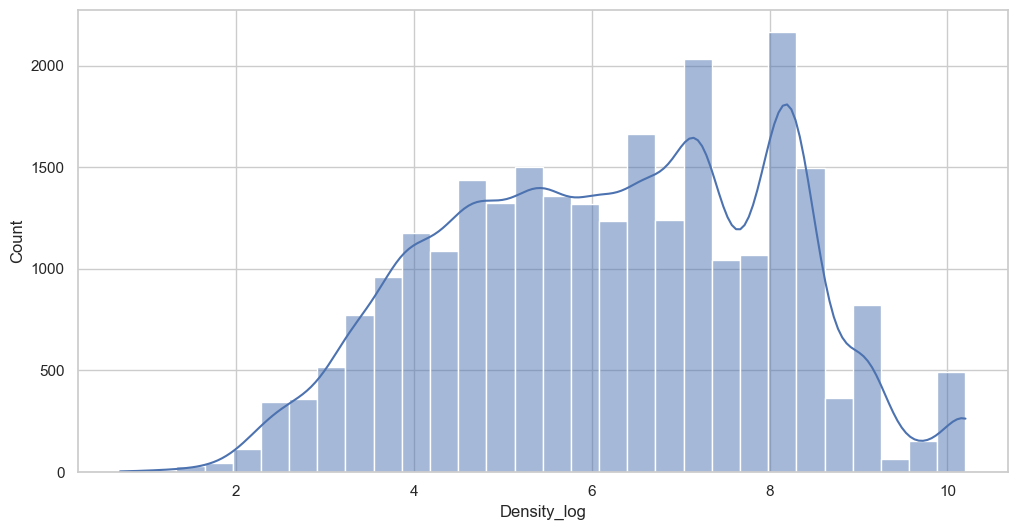

In [454]:
# create a variable for density log
log_transform(df_merged, 'Density')
#plot new variable
plt.figure(figsize=(12, 6))
sns.histplot(df_merged['Density_log'], bins=30, kde=True)
plt.show()


### Interaction Term: DriverAge * Vehicle Age

I will create an interaction term between DrivAge and VehAge to explore the relationship between the driver’s experience and the condition or age of the vehicle they are driving. This term could reveal how the combination of these two factors influences the risk profile, potentially enhancing the model’s predictive accuracy.


In [455]:
#create interaction term between DrivAge and VehAge
df_merged['DrivAge_VehAge'] = df_merged['DrivAge'] * df_merged['VehAge']

## Discussion
**Potential Issues:**

1. **Multicollinearity:**
   - Be cautious of multicollinearity, particularly between BonusMalus and Age. Understanding how BonusMalus is assigned is crucial, as a strong correlation between these variables could lead to multicollinearity problems in the model. Most of the other variables, including those related to the driver’s age, vehicle age, and exposure, have very weak correlations with the target, suggesting they might not be strong standalone predictors in a linear model.

2. **Insufficient Predictive Data:**
   - There might be a lack of sufficient predictor data, which could hinder the effectiveness of the modeling process.

3. **Variations in Insurance Types:**
   - Consider whether there are different types of insurance policies within the dataset, as this could introduce additional complexity or require separate treatment.

**Variables I Have Created:**

1. **log(Density):**
   - A logarithmic transformation of the Density variable to address skewness and stabilize variance.

2. **DriverExperience:**
   - A variable estimating the driver’s experience based on their age and the assumption that they started driving at 18.

3. **ClaimFrequency:**
   - A variable capturing the frequency of claims made by each driver.

4. **BonusMalus Binary:**
   - A binary version of the BonusMalus variable to distinguish between drivers with bonuses and those with malus.

5. **Statistical Descriptions:**
   - Generated statistical summaries for key variables, such as region and vehicle brand, to provide deeper insights and improve the modeling process.

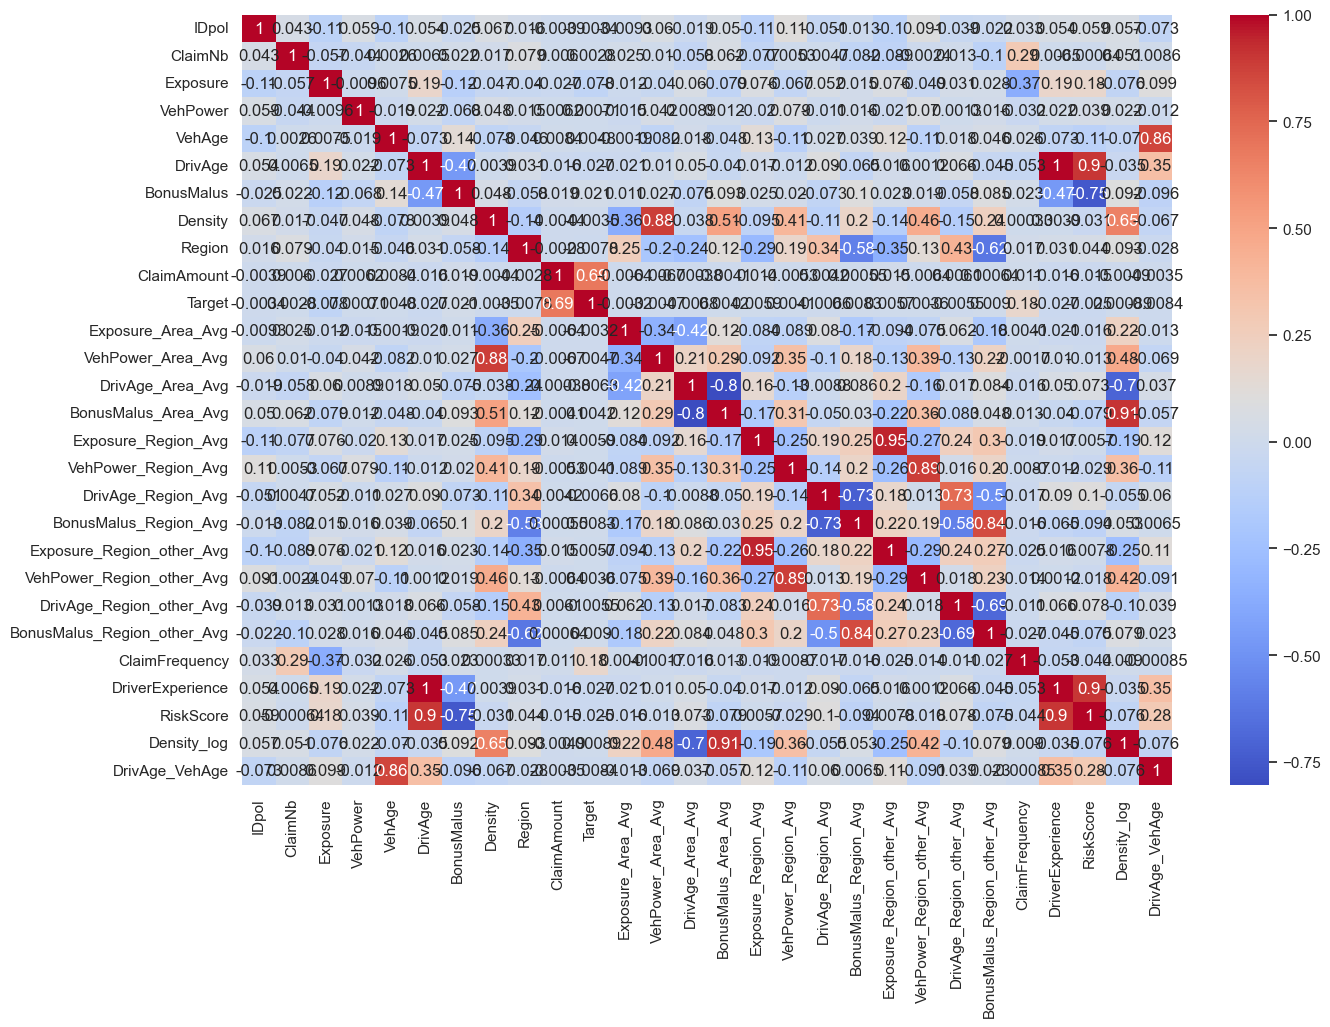

Target                         1.000000
ClaimAmount                    0.685322
ClaimFrequency                 0.180455
BonusMalus                     0.021335
BonusMalus_Region_other_Avg    0.008958
BonusMalus_Region_Avg          0.008295
Exposure_Region_Avg            0.005879
Exposure_Region_other_Avg      0.005745
VehAge                         0.004796
BonusMalus_Area_Avg            0.004218
VehPower_Region_Avg            0.004081
VehPower_Region_other_Avg      0.003610
ClaimNb                        0.002841
Density_log                    0.000887
VehPower                       0.000712
Exposure_Area_Avg             -0.003229
IDpol                         -0.003364
Density                       -0.003500
VehPower_Area_Avg             -0.004660
DrivAge_Region_other_Avg      -0.005455
DrivAge_Region_Avg            -0.006584
DrivAge_Area_Avg              -0.006843
Region                        -0.007775
DrivAge_VehAge                -0.008442
RiskScore                     -0.025204


In [456]:
corr_map = df_merged.select_dtypes(include = [np.number]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_map, annot=True, cmap='coolwarm')
plt.show()
#get the corr for Target variable
corr_target = corr_map['Target'].sort_values(ascending=False)
corr_target

In [457]:
#drop density, claim amount and adapted variables exposure to prevent data leakage
#drop DrivAge column
columns_to_drop = ['DrivAge', 'BonusMalus', 'VehPower', 'VehBrand', 'Density']


#additional f

#save the cleaned data
df_merged.to_csv('../data/cleaned_data.csv', index=False)
data_merged.to_csv('../data/raw_data.csv', index=False)